# Hw3
We solve the polynomial fitting problem using two methods: Householder Triangularization and Modified Gram-Schmit Orthogonalization. From our experience we expect that Householder triangularization will be more stable.

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

 The data point $t_i$ is equally spaced on the interval [0, 1], and the corresponding variable y is valued through the polynimial:
 $p_{n-1}(t) = x_1 + x_2t + x_3 t^2+ ... + x_nt^{n-1}$
 with all coefficients equals 1. So the truth of the problem is a ones vector with length n.

In [225]:
def data_gen(m, n):
# m is the number of data points; n-1 is the order of polynomial; m>n
    t_i = np.linspace(0, 1, m)
    A = np.vander(t_i, n, increasing=True) # Data matrix is a Vandermonde matrix
    x_truth = np.ones(n)
    y_i = A @ x_truth
    
    return t_i, A, x_truth, y_i

The algorithm of Householder triangularization follows 
$$
\begin{bmatrix}
I & 0  \\
0 & F \\
\end{bmatrix}
$$
with F be the reflector:
$$
F = I - 2 \frac{vv^T}{v^T v}
$$
v is the difference between x vector and the rotation of x towards one basis. In reality we normaliza every v and then compute $\hat{Q}^T b$ at the same time

In [226]:
def householder(A, b):
    n = A.shape[1]
    for k in range(0, n):
        x = A[k:, k]
        e = np.zeros_like(x)
        e[0] = np.linalg.norm(x) 
        v_k = np.sign(x[0])*e + x # Choose the reflector which is further from x 
        v_k = v_k / np.linalg.norm(v_k)
        A[k:, k:] = A[k:, k:] - 2 * np.outer(v_k, v_k.T @ A[k:, k:])
        b[k:] = b[k:] - 2 * np.dot(v_k, b[k:]) * v_k # Do not explicitly compute Q, but multiple b by Q_i at every loop

    A_zero_rows = A[n:, :]
    b_zero_rows = b[n:]

    if np.all(np.abs(A_zero_rows) < 1e-10) & np.all(np.abs(b_zero_rows) < 1e-10):
        A_hat = A[:n, :]
        b_hat = b[:n] # Because we are doing reduced QR, the last m-n of Q^T*b can be set to zero
    else:
        raise ValueError("Incorrect triangulization")
    return A_hat, b_hat


For modified Gram-Schmit, it is similar to ordinary Gram-Schimit, but the first row of R matrix is computed first. We can say at ith loop we extract component in the ith basis from every latter columns.

In [227]:
def MGC(A):
    n = A.shape[1]
    R = np.zeros((n, n))
    for i in range(0,n):
        R[i, i] = np.linalg.norm(A[:, i])
        A[:, i] = A[:, i] / R[i, i]
        for j in range(i+1, n):
            R[i, j] = np.dot(A[:, i], A[:, j])
            A[:, j] = A[:, j] - R[i, j]*A[:, i] # Rewrite A with Q.
    return A, R

In [228]:
def back_sub(R, b):

    m = R.shape[0]
    n = R.shape[1] 
    for i in range(m-1, -1, -1):
        b[i] = (b[i] - np.dot(R[i, (i+1):], b[(i+1):])) / R[i, i]
    return b

In [229]:
def householder_exp(order):

    _, A, x_truth, y_i = data_gen(2*order, order)
    R, b = householder(A, y_i)
    x_cal = back_sub(R, b)
    error = np.linalg.norm(x_cal - x_truth)

    return error
        

In [230]:
def MGC_exp(order):
    
    _, A, x_truth, y_i = data_gen(2*order, order)
    Q, R = MGC(A)
    x_cal = back_sub(R, Q.T @ y_i)
    error = np.linalg.norm(x_cal - x_truth)

    return error

To make comparsions, we have polynomial order from 3 to 16. Also the error and the runtime is averaged on 100 times.

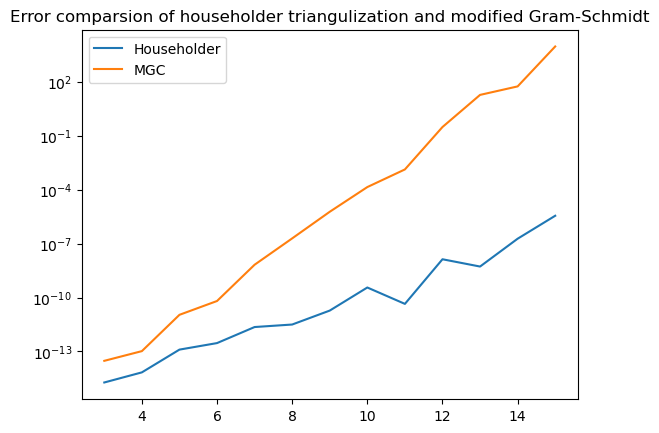

In [231]:
order_list = [i for i in range(3,16,1)]
H_error_list = [0] * len(order_list) # cannot use zero_like here, or will lose precision and may get all 0 in error list
H_runtime_list = [0] * len(order_list)
M_error_list = [0] * len(order_list)
M_runtime_list = [0] * len(order_list)

for i, n in enumerate(order_list):
    H_error_list[i] = np.mean([householder_exp(n) for _ in range(100)]) 
    H_runtime_list[i] = timeit.timeit("householder_exp(n)", globals=globals(), number=1000) / 1000

for i, n in enumerate(order_list):
    M_error_list[i] = np.mean([MGC_exp(n) for _ in range(100)]) 
    M_runtime_list[i] = timeit.timeit("MGC_exp(n)", globals=globals(), number=1000) / 1000

plt.plot(order_list, H_error_list, label='Householder')
plt.plot(order_list, M_error_list, label='MGC')
plt.title('Error comparsion of householder triangulization and modified Gram-Schmidt')
plt.yscale('log')
plt.legend()
plt.show()

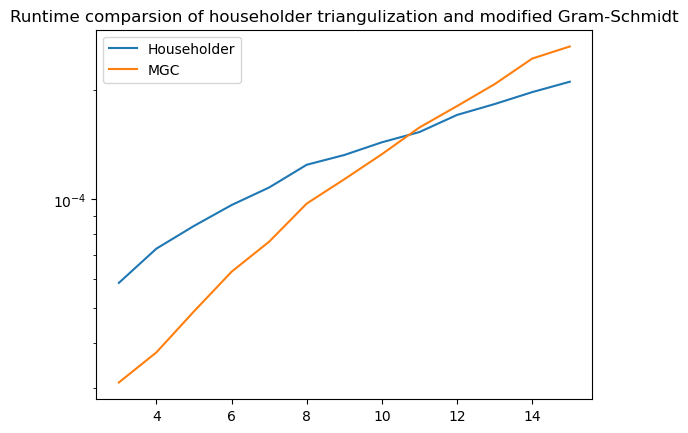

In [232]:
plt.plot(order_list, H_runtime_list, label='Householder')
plt.plot(order_list, M_runtime_list, label='MGC')
plt.title('Runtime comparsion of householder triangulization and modified Gram-Schmidt')
plt.yscale('log')
plt.legend()
plt.show()

The error comparsion confirm our expectation: the error of MGC for polynomial fitting greatly exceed that for Householder Triangularization.
For efficiency comparision, we see the growing trend of MGC is larger than Householder triangularization.